In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import math
from utils import *
import argparse
from matplotlib.legend_handler import HandlerLine2D
from utils import *
from model import *
from data import *

In [2]:
# 批量预测
def last_word_acc(model, data, batch_size=-1, b=0):
    # 如果预测的最后一个词跟句子的最后一个词一样，视为预测正确
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    data = np.array(data)
    if batch_size == -1:
        batch_size = np.size(data, 0)
    train_dataset = MyDataSet(data)
    data_loader = Data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, 
                                        drop_last=False, collate_fn=train_dataset.padding_batch)
    
    for i, (dec_inputs, dec_outputs) in enumerate(data_loader):  
        dec_inputs, dec_outputs = dec_inputs.to(device), dec_outputs.to(device)
        outputs, _ = model(dec_inputs) 
        outputs = outputs.argmax(axis=-1).view(-1, np.size(data, 1)-1)
        correct += (outputs[:, -1] == dec_outputs[:, -1]+b).sum().item()

    return correct / len(data_loader.dataset) 

In [3]:
exp_dir = 'result/GPT_每个anchor有各自的区间'
# working_dir = f'{exp_dir}/345x_three_interval-seed_1-N_18000-4L4H_区间20-70_区间20-100_区间50-100'
# working_dir = f'{exp_dir}/multianchor_multiinterval-seed_1-N_20000-4L4H'
working_dir = f'{exp_dir}/multianchor_multiinterval-seed_1-N_20000-4L4H_lr1e-4'
# working_dir = f'{exp_dir}/multianchor_multiinterval-seed_1-N_10000-4H4L'

# exp_dir = 'result/GPT_每个anchor有各自的区间_大数据量大batch'
# # working_dir = f'{exp_dir}/345x_three_interval-seed_1-N_18000-4L4H_区间20-70_区间20-100_区间50-100'
# # working_dir = f'{exp_dir}/multianchor_multiinterval-seed_1-N_20000-8L1H'
# working_dir = f'{exp_dir}/multianchor_multiinterval-seed_1-N_50000-4H4L'
# working_dir = f'{exp_dir}/multianchor_multiinterval-seed_1-N_20000-4H4L'
# state_dict=torch.load(f'{working_dir}/model/model_3999.pt')
state_dict=torch.load(f'{working_dir}/model/model_440.pt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = load_args(f'{working_dir}/config.json')

model = myGPT(args, device)
model.load_state_dict(state_dict)
model.to(device)

myGPT(
  (decoder): Decoder(
    (tgt_emb): Embedding(201, 400)
    (pos_emb): Embedding(20, 400)
    (layers): ModuleList(
      (0-7): 8 x DecoderLayer(
        (dec_self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=400, out_features=384, bias=False)
          (W_K): Linear(in_features=400, out_features=384, bias=False)
          (W_V): Linear(in_features=400, out_features=384, bias=False)
          (fc): Linear(in_features=384, out_features=400, bias=False)
          (layernorm): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
        )
        (pos_ffn): PoswiseFeedForwardNet(
          (fc): Sequential(
            (0): Linear(in_features=400, out_features=1200, bias=False)
            (1): ReLU()
            (2): Linear(in_features=1200, out_features=400, bias=False)
          )
          (layernorm): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
  )
  (projection): Linear(in_features=400, out_features=201, bias=True)
)

各anchor在seen和unseen interval的准确率

In [4]:
args.train_data_size = 1000
args.test_data_size = 0
train_acc_list = []
test_acc_list = []
for i in range(1, 11):
    for c in ['False', 'True']:
        kwargs = {'use_mod_list_specific': 'True', 'prompt': f'{i}', 'unseen interval': c}
        datas = get_data(args, True, **kwargs)

        train_data = datas['train_seq_group']
        # test_data = datas['test_seq_group']

        train_acc = last_word_acc(model, train_data['full data'], batch_size=1000, b=0)
        # test_acc = last_word_acc(model, test_data['full data'], batch_size=1000, b=0)

        # print(f'prompt: {i}, unseen interval: {c}, train acc: {train_acc}, test acc: {test_acc}')

        print(f'prompt: {i}, unseen interval: {c}, train acc: {train_acc}')

        train_acc_list.append(train_acc)
        # test_acc_list.append(test_acc)

train_acc_list = np.array(train_acc_list).reshape((10, 2))
# test_acc_list = np.array(test_acc_list).reshape((10, 2))


/nfs/my/data/model_compare/data.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  decoder_inputs = torch.tensor([d["decoder_input"] for d in batch], dtype=torch.long)


prompt: 1, unseen interval: False, train acc: 1.0
prompt: 1, unseen interval: True, train acc: 0.863
prompt: 2, unseen interval: False, train acc: 1.0
prompt: 2, unseen interval: True, train acc: 0.877
prompt: 3, unseen interval: False, train acc: 1.0
prompt: 3, unseen interval: True, train acc: 0.999
prompt: 4, unseen interval: False, train acc: 1.0
prompt: 4, unseen interval: True, train acc: 0.999
prompt: 5, unseen interval: False, train acc: 0.997
prompt: 5, unseen interval: True, train acc: 0.996
prompt: 6, unseen interval: False, train acc: 0.999
prompt: 6, unseen interval: True, train acc: 1.0
prompt: 7, unseen interval: False, train acc: 1.0
prompt: 7, unseen interval: True, train acc: 0.997
prompt: 8, unseen interval: False, train acc: 1.0
prompt: 8, unseen interval: True, train acc: 0.998
prompt: 9, unseen interval: False, train acc: 0.999
prompt: 9, unseen interval: True, train acc: 0.995
prompt: 10, unseen interval: False, train acc: 1.0
prompt: 10, unseen interval: True, t

In [28]:
def plot_multiinterval_acc():
    fig = plt.figure(figsize=(12, 6))
    format_settings(left=0.18, right=0.98, bottom=0.18, top=0.88, major_tick_len=5, major_tick_width=2, fs=32, axlw=2)
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    width=0.35
    plt.bar(np.arange(10)-width/2, train_acc_list[:, 0], width=width, label=r'$x\in G_a$', edgecolor='black', linewidth=2)
    plt.bar(np.arange(10)+width/2, train_acc_list[:, 1], width=width, label=r'$x\in G_a^c$', edgecolor='black', linewidth=2)
    plt.xticks(np.arange(10), np.arange(1, 11))
    plt.yticks([0.2, 0.6, 1.0], ['20%', '60%', '100%'])
    plt.xlabel('Anchor')
    plt.ylabel('Accuracy')

    plt.legend(loc=(0, 1.02), frameon=False, ncol=2, fontsize=24)
    plt.savefig(f'{working_dir}/acc.png', dpi=300)
    print(f'saved at {working_dir}/acc.png')
    plt.show()

saved at result/GPT_每个anchor有各自的区间/multianchor_multiinterval-seed_1-N_20000-4L4H_lr1e-4/acc.png


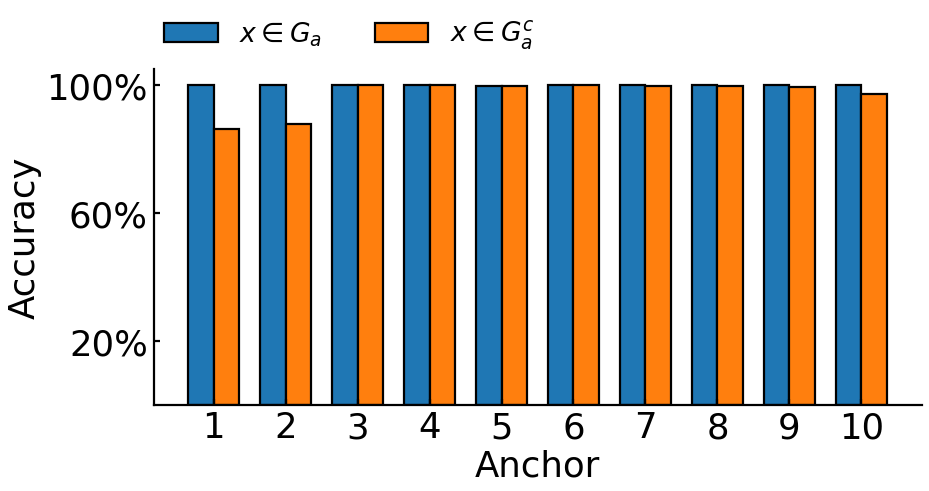

In [29]:
plot_multiinterval_acc()

In [11]:
args.train_data_size = 1000
args.test_data_size = 1000
i=7
b='True'
# b = 'False'
kwargs = {'use_mod_list_specific': 'True', 'prompt': f'{i}', 'unseen interval': b}
datas = get_data(args, True, **kwargs)

train_data = datas['train_seq_group']
test_data = datas['test_seq_group']

p_train = 0
p_test = 0
for t in range(1, 11):
    train_acc = last_word_acc(model, train_data['full data'], batch_size=1000, b=t-i)
    test_acc = last_word_acc(model, test_data['full data'], batch_size=1000, b=t-i)
    
    p_train += train_acc
    p_test += test_acc

    print(f'prompt: {i}, learned: x+({t}), train acc: {train_acc}, test acc: {test_acc}')

print(p_train, p_test)

prompt: 7, learned: x+(1), train acc: 0.0, test acc: 0.0
prompt: 7, learned: x+(2), train acc: 0.0, test acc: 0.0
prompt: 7, learned: x+(3), train acc: 0.0, test acc: 0.0
prompt: 7, learned: x+(4), train acc: 0.0, test acc: 0.0
prompt: 7, learned: x+(5), train acc: 0.0, test acc: 0.0
prompt: 7, learned: x+(6), train acc: 0.0, test acc: 0.0
prompt: 7, learned: x+(7), train acc: 1.0, test acc: 0.981
prompt: 7, learned: x+(8), train acc: 0.0, test acc: 0.0
prompt: 7, learned: x+(9), train acc: 0.0, test acc: 0.0
prompt: 7, learned: x+(10), train acc: 0.0, test acc: 0.0
1.0 0.981


prompt: 10, x: 92 1.0 1.0


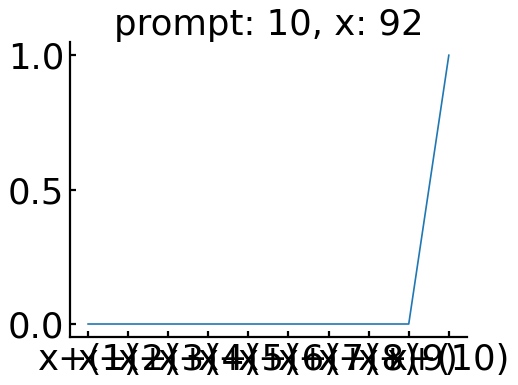

prompt: 10, x: 93 1.0 1.0


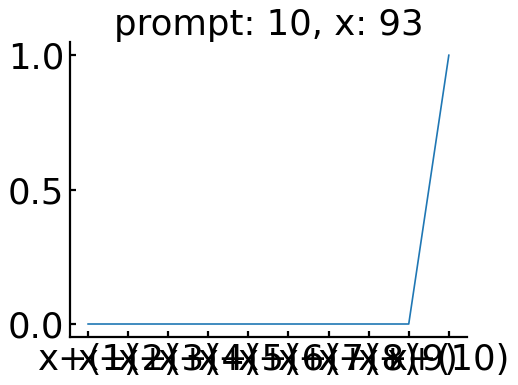

prompt: 10, x: 94 0.922 0.903


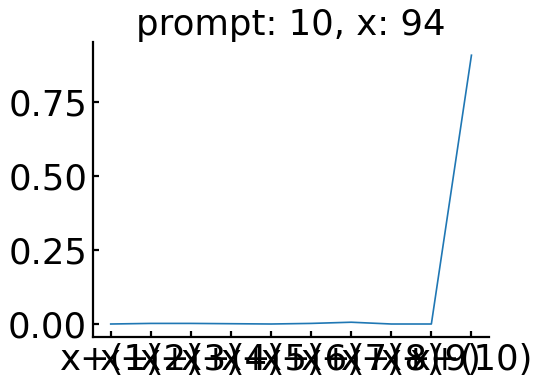

prompt: 10, x: 95 1.0 0.999


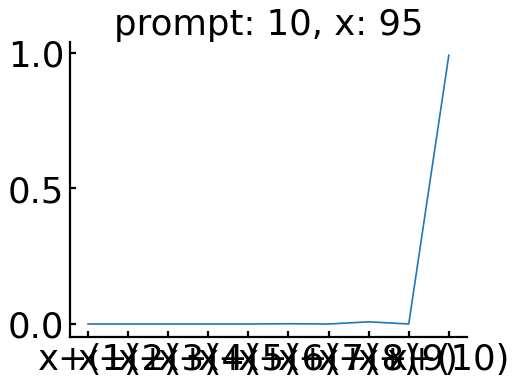

prompt: 10, x: 96 1.0 1.0


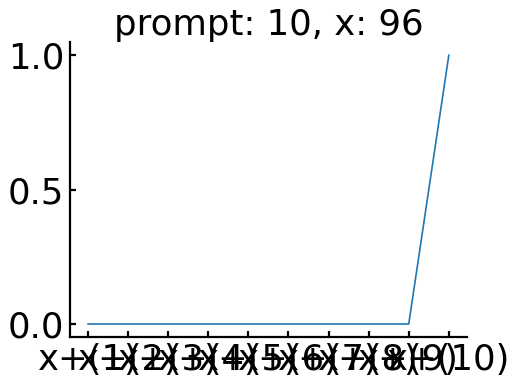

prompt: 10, x: 97 0.962 0.972


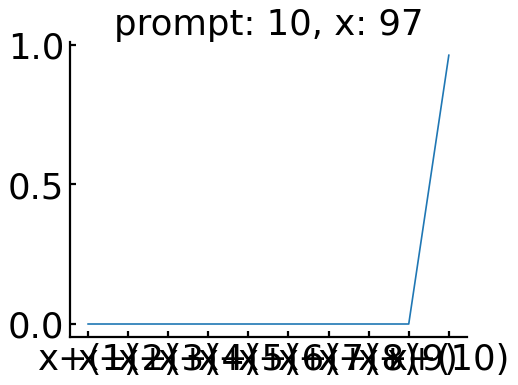

prompt: 10, x: 98 1.0 1.0


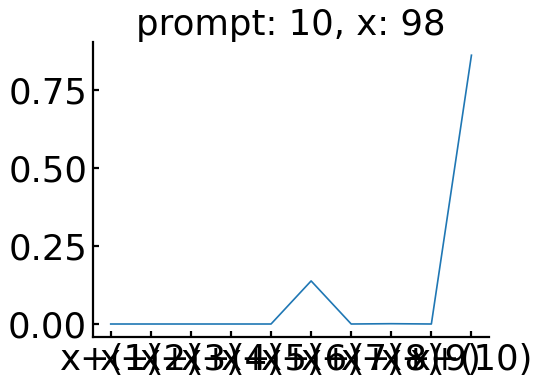

prompt: 10, x: 99 0.825 0.807


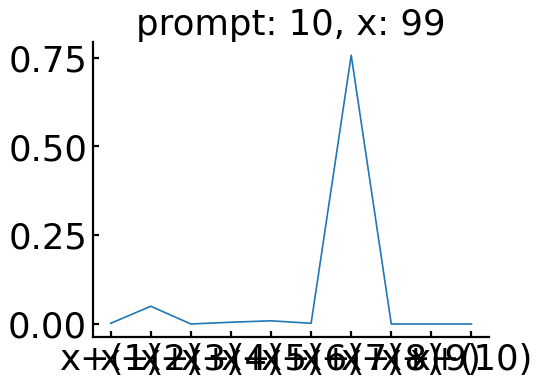

In [7]:
args.train_data_size = 1000
args.test_data_size = 1000
i=10
b='True'
for x in range(20+8*(i-1), 20+8*(i)):
    kwargs = {'use_mod_list_specific': 'True', 'prompt': f'{i}', 'unseen interval': b, 'x': x}
    datas = get_data(args, True, **kwargs)
    train_data = datas['train_seq_group']
    test_data = datas['test_seq_group']

    p_train = 0
    p_test = 0
    p_train_list = []
    p_test_list = []
    x_ticks = []
    for t in range(1, 11):
        train_acc = last_word_acc(model, train_data['full data'], batch_size=1000, b=t-i)
        test_acc = last_word_acc(model, test_data['full data'], batch_size=1000, b=t-i)
        p_train += train_acc
        p_test += test_acc
        p_train_list.append(train_acc)
        p_test_list.append(test_acc)
        x_ticks.append(f'x+({t})')

        # print(f'prompt: {i}, x: {x}, learned: x+({t}), train acc: {train_acc}, test acc: {test_acc}')
    print(f'prompt: {i}, x: {x}', p_train, p_test)
    fig = plt.figure()
    plt.plot(p_train_list, label='train')
    # plt.plot(p_test_list, label='test')
    plt.xticks(range(0, 10), x_ticks)
    plt.title(f'prompt: {i}, x: {x}')
    plt.show()

各anchor学到各个类别的准确率

In [19]:
args.train_data_size = 1000
args.test_data_size = 0
b='True'
# b = 'False'
accuracy_array = np.zeros((10, 10))

for anchor in range(1, 11):
    kwargs = {'use_mod_list_specific': 'True', 'prompt': f'{anchor}', 'unseen interval': b}
    datas = get_data(args, True, **kwargs)

    train_data = datas['train_seq_group']
    p_train = 0
    for t in range(1, 11):
        train_acc = last_word_acc(model, train_data['full data'], batch_size=1000, b=t-anchor)
        
        p_train += train_acc

        print(f'prompt: {anchor}, learned: x+({t}), train acc: {train_acc}')

        accuracy_array[anchor-1, t-1] = train_acc

    # accuracy_array[anchor-1, 10] = 1 - p_train

prompt: 1, learned: x+(1), train acc: 0.837
prompt: 1, learned: x+(2), train acc: 0.001
prompt: 1, learned: x+(3), train acc: 0.0
prompt: 1, learned: x+(4), train acc: 0.016
prompt: 1, learned: x+(5), train acc: 0.0
prompt: 1, learned: x+(6), train acc: 0.0
prompt: 1, learned: x+(7), train acc: 0.146
prompt: 1, learned: x+(8), train acc: 0.0
prompt: 1, learned: x+(9), train acc: 0.0
prompt: 1, learned: x+(10), train acc: 0.0
prompt: 2, learned: x+(1), train acc: 0.0
prompt: 2, learned: x+(2), train acc: 0.871
prompt: 2, learned: x+(3), train acc: 0.0
prompt: 2, learned: x+(4), train acc: 0.001
prompt: 2, learned: x+(5), train acc: 0.108
prompt: 2, learned: x+(6), train acc: 0.015
prompt: 2, learned: x+(7), train acc: 0.0
prompt: 2, learned: x+(8), train acc: 0.001
prompt: 2, learned: x+(9), train acc: 0.0
prompt: 2, learned: x+(10), train acc: 0.0
prompt: 3, learned: x+(1), train acc: 0.0
prompt: 3, learned: x+(2), train acc: 0.0
prompt: 3, learned: x+(3), train acc: 0.999
prompt: 3, l

Text(0.5, 0, 'b (Learned x+b)')

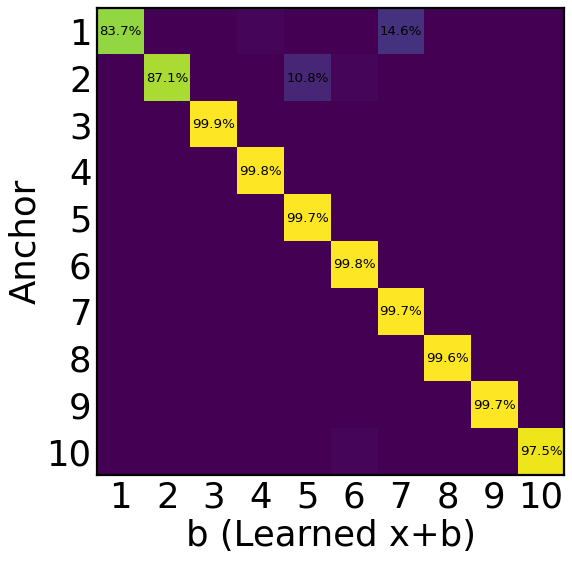

In [21]:
fig = plt.figure(figsize=(12, 8))
format_settings(left=0.18, right=0.98, bottom=0.15, top=0.88, major_tick_len=5, major_tick_width=0, fs=32, axlw=2)
plt.imshow(accuracy_array, interpolation='nearest')
# 对于数据大于0.1的地方标注出来
for i in range(10):
    for j in range(10):
        if accuracy_array[i, j] > 0.05:
            plt.text(j, i, '{:.1%}'.format(accuracy_array[i, j]), ha='center', va='center', fontsize=12)
plt.yticks(np.arange(10), np.arange(1, 11))
plt.xticks(np.arange(10), [1,2,3,4,5,6,7,8,9,10])
plt.ylabel('Anchor')
plt.xlabel('b (Learned x+b)')

In [8]:
print(datas['train_seq_group']['full data'][20:40])

[[31, 42, 10, 26, 37, 93, 44, 82, 99, 36], [86, 10, 95, 45, 68, 23, 88, 35, 92, 105], [98, 40, 70, 22, 10, 72, 91, 63, 25, 82], [33, 29, 27, 20, 95, 20, 10, 22, 76, 32], [62, 68, 10, 33, 88, 22, 90, 76, 66, 43], [10, 29, 93, 60, 61, 46, 31, 30, 54, 39], [22, 70, 10, 97, 69, 50, 52, 79, 90, 107], [89, 39, 10, 54, 42, 24, 34, 83, 85, 64], [81, 10, 77, 92, 34, 53, 44, 68, 41, 87], [20, 27, 22, 75, 40, 36, 10, 38, 67, 48], [50, 69, 28, 65, 60, 58, 10, 40, 48, 50], [99, 92, 10, 76, 49, 96, 34, 96, 75, 86], [71, 78, 98, 10, 67, 22, 46, 41, 73, 77], [33, 99, 48, 47, 45, 31, 37, 10, 30, 40], [24, 55, 55, 33, 10, 41, 44, 64, 37, 51], [32, 10, 59, 67, 59, 63, 73, 36, 98, 69], [58, 64, 36, 61, 47, 65, 10, 48, 29, 58], [33, 87, 96, 10, 41, 25, 25, 78, 83, 51], [39, 20, 92, 34, 75, 10, 50, 22, 28, 60], [53, 50, 10, 58, 23, 22, 36, 30, 42, 68]]
